# ImageJ: Multidimensional processing

:::{admonition} Work in progress!
:class: warning

This section isn't complete yet.
It's really just a scattered collection of thoughts for now.
:::

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

This section gives a brief overview of some things to think about when working with z-stacks and time series in ImageJ.

## Point operations, contrast & conversion

Point operations are straightforward: they depend only on individual pixels, so the number of dimensions is unimportant.
Image arithmetic involving a 3D stack and a 2D image can also be carried out in ImageJ using the {menuselection}`Process --> Image Calculator`, where the operation involving the 2D image is applied to each slice of the 3D stack in turn.
Other options, such as filtering and thresholding, are possible, but bring with them extra considerations -- and often significantly higher computational costs.

Setting the LUT of a 3D image requires particular care.
The normal {menuselection}`Brightness/Contrast...` tool only takes the currently-displayed slice into consideration when pressing {guilabel}`Reset` or {guilabel}`Auto`.
Optimizing the display for a single slice does not necessarily mean the rest of the stack will look reasonable if the brightness changes much. {menuselection}`Process --> Enhance Contrast...` is a better choice, since here you can specify that the information in the entire stack should be used.
You can also specify the percentage of pixels that should be saturated (clipped) _for display_, i.e. those that should be shown with the first or last colors in the LUT.
So long as {guilabel}`Normalize` and {guilabel}`Equalize histogram` are not selected, the pixel values shouldn't be changed.


```{tabbed} Question
:new-group:

By default, the percentage of saturated pixels in {menuselection}`Enhance Contrast...` is set to 0.4.
Why might this be chosen instead of 0?


```


```{tabbed} Solution

If the percentage of saturated pixels is 0, then the minimum and maximum pixel values throughout the image will be given the first and last LUT colors respectively, with all other colors devoted to values in between.
This is sensitive to outliers, and often results in images that have poor contrast.
It's usually better to accept some small amount of visual saturation, in order to give more LUT colors to the pixel values between the extremes.
```




:::{admonition} Converting bit-depths of multidimensional images
:class: info

As described in {ref}`Types & bit-depths<sec_bit_depths_converting>`, the minimum and maximum display range values are used by default when reducing the bit-depth of an image.
To minimize the information lost, these should usually be set to the minimum and maximum pixel values within the image – otherwise values will be clipped.

In 2D it's enough to press {guilabel}`Reset` in the {menuselection}`Brightness/Contrast` window, _but in 3D this will only work if the minimum and maximum values from the entire stack happen to appear on the current slice!_

For this reason, it's good practice to run {menuselection}`Enhance Contrast...` prior to reducing bit-depths of stacks, setting the saturation to 0 and using the entire stack.
This means no pixels will be clipped in the output (although rescaling and rounding will still occur).
:::

## 3D filtering

Many filters naturally lend themselves to being applied to as many dimensions as are required.
For example, a 3×3 mean filter can easily become a 3×3×3 filter if averaging across slices is allowed.
Importantly, it then replaces each pixel by the average of 27 values, rather than 9.

This implies the reduction in noise is *somewhat* similar to that of applying a 5×5 filter (25 values), but with a little less blurring in 2D and a little more along the third dimension instead.
Several 3D filters are available under the {menuselection}`Plugins --> Process -->` submenu.

### Fast, separable filters

{menuselection}`Process --> Filters --> Gaussian Blur 3D...` uses this approach.




:::{admonition} Fast filters & the Fourier transform
:class: info

Not all linear filters are separable, and applying a large, non-separable linear filter can also be extremely time-consuming.
However, when this is the case a whole other method can be used to get the same result using the Fourier transform – where the speed no longer has the same dependence upon the filter size. Unfortunately, the Fourier method cannot be used for non-linear filters such as the median filter.
:::

### Dimensions & isotropy

If applying a filter in 3D instead of 2D, it may seem natural to define it as having the same size in the third dimension as in the original two.
But for a __z__-stack, the spacing between slices is usually larger than the width and height of a pixel.
And if the third dimension is time, then it uses another scale entirely.
Therefore more thought usually needs to be given to what sizes make most sense.

In some commands (e.g.
{menuselection}`Plugins --> Process --> Smooth (3D)`), there is a {guilabel}`Use calibration` option to determine whether the values you enter are defined in terms of the units found in the {menuselection}`Properties...` and therefore corrected for the stored pixel dimensions.
Elsewhere (e.g. {menuselection}`Gaussian Blur 3D...`) the units are pixels, slices and time points – and so you are responsible for figuring out how to compensate for different scales and units.

## Thresholding multidimensional data

When thresholding an image with more than 2 dimensions using the {menuselection}`Threshold...` command, it is necessary to choose whether the threshold should be determined from the histogram of the entire stack, or from the currently-visible 2D slice only.
If the latter, you will also be asked whether the same threshold should be used for every slice, or if it should be calculated anew for each slice based upon the slice histogram. In some circumstances, these choices can have a very large impact upon the result.


```{tabbed} Question
:new-group:

When you threshold a stack, you have an option to choose {guilabel}`Stack Histogram`. Then, when you choose {guilabel}`Apply` you are asked if you want to {guilabel}`Calculate Threshold for Each Image`.
What difference do you expect these two options to make, and what combinations would you use for:


1.  a stack consisting of 2D images from different color channels
2.  a __z__-stack
3.  a time series

_Note:_ Have a look at what happens when you click {guilabel}`Auto` while scrolling through one channel of the stack {menuselection}`File --> Open samples --> Mitosis (26 MB, 5D Stack)`, with and without {guilabel}`Stack Histogram` selected.
You will have to split the channels for this because ImageJ currently refuses to threshold multichannel images with extra dimensions (which helps avoid some confusion).
{guilabel}`Dark Background` should always be selected here.


```


```{tabbed} Solution

If {guilabel}`Stack Histogram` is checked, the thresholds are computed from a histogram of all the pixels in the entire image stack; otherwise, the histogram of only the currently-displayed image slice is used.

BUT! If {guilabel}`Calculate Threshold for Each Image` is chosen, then this is ignored: the threshold is always determined by the selected automatic method using the histogram of the corresponding slice only.

Therefore, the most sensible combinations of thresholding options to use depend upon the type of data.


1.  _color channels_ – There is often no good reason to suppose the amount of fluorescence in different color channels will be similar, and so thresholds should be calculated from each channel independently.
2.  _z-Stacks_ – It is normally a good idea to use the stack histogram with __z__-stacks.
If you do not, then your threshold will be affected by whatever slice you happen to be viewing at the time of thresholding – introducing a potentially weird source of variability in the results.
It is probably _not_ a good idea to calculate a new threshold for each slice, because this would lead to at least _something_ being detected on every slice.
But in the outer slices there may well only be blur and noise – in which case nothing _should_ be detected!
3.  _Time series_ – In a time series, bleaching can sometimes cause the image to darken over time.
In such a case, using the stack histogram might cause fewer pixels to exceed the threshold at later time points simply for this reason, and recalculating the threshold for each image may be better.
On the other hand, if images were previously normalized somehow to compensate for bleaching [^fn_1], then the stack threshold might be preferable again.
It's tricky.

[^fn_1]: See http://imagej.net/Bleach_Correction


There is one other implementation issue that needs attention.
When {guilabel}`Dark Background` is checked and an automated threshold is computed, then it is only really the low threshold that matters – the high threshold is always set to the maximum in the histogram to ensure that all brighter pixels are designated 'foreground' in the result.
However, if not using {guilabel}`Stack Histogram`, then for non-8-bit images the histograms are calculated using the minimum and maximum pixels on the slice, and consequently the high threshold cannot be higher than this maximum value (look at how the high threshold value changes in {menuselection}`Mitosis` as you compute auto thresholds for different slices).
This means that any brighter pixels will be _outside_ the threshold range (and therefore 'background') if they occur on a different slice.
This can cause holes to appear in the brightest parts of structures, and is probably not what you want.
A similar situation occurs with the low threshold when {guilabel}`Dark Background` is unchecked.
```

## Measurements in 3D data

ImageJ has good support for making measurements in 2D, particularly the {menuselection}`Measure` and {menuselection}`Analyze Particles...` commands. The latter can happily handle 3D images, but only by creating and measuring 2D ROIs independently on each slice.
Alternatively, {menuselection}`Image --> Stacks --> Plot Z-axis Profile` is like applying {menuselection}`Measure` to each slice independently, making measurements either over the entire image or any ROI.
It will also plot the mean pixel values, but even if you do not particularly want this the command can still be useful.
However, if single measurements should be made for individual objects that extend across multiple slices, neither of these options would be enough.

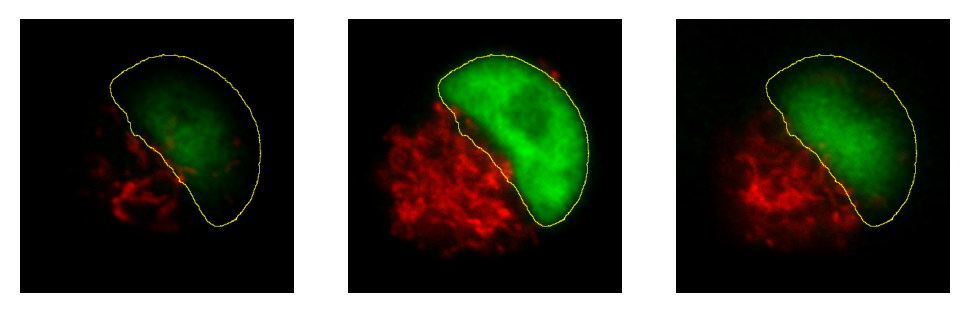

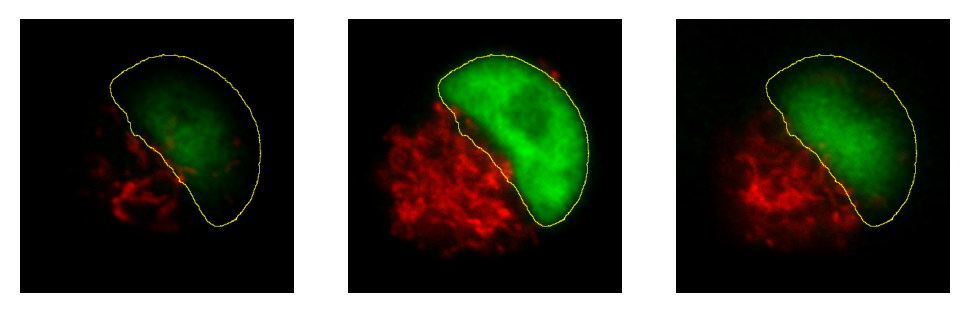

In [2]:
fig = create_figure(figsize=(6, 4))
show_image('images/widest_roi_1.png', pos=131)
show_image('images/widest_roi_2.png', pos=132)
show_image('images/widest_roi_3.png', pos=133)
glue_fig('fig_multidimensional_widest', fig)

::::{tabbed} Practical
:new-group:

Suppose you have a cell, nucleus or some other large 3D structure in a __z__-stack, and you want to draw the smallest 2D ROI that completely contains it on every slice.
An example is shown below for the green structure in the {menuselection}`Confocal Series` sample image.

How would you create such a ROI, and be confident that it is large enough for all slices?

```{glue:figure} fig_multidimensional_widest
```

::::


:::{tabbed} Solution

My strategy would be to create a z-projection (max intensity) and then draw the ROI on this – or, preferably, create the ROI by thresholding using {menuselection}`Image --> Adjust --> Threshold` and the {guilabel}`Wand` tool.
This ROI can then be transferred over to the original stack, either via the ROI Manager or {menuselection}`Edit --> Selection --> Restore Selection`.
:::



### Histograms & threshold clipping

One way to measure in 3D is to use the {menuselection}`Histogram` command and specify that the entire stack should be included – this provides some basic statistics, including the total number, mean, minimum, maximum and standard deviation of the pixels [^fn_2].
This will respect the boundaries of a 2D ROI if one has been drawn.

[^fn_2]: Be careful! If you have multiple channels, these should be split first


This is a start, but it will not adjust to changes in the object boundary on each 2D plane.
A better approach could be to use {menuselection}`Image --> Adjust --> Threshold...` to set a threshold that identifies the object – but do _not_ press {guilabel}`Apply` to generate a binary image.
Rather, under {menuselection}`Analyze --> Set Measurements...` select {guilabel}`Limit to threshold`.
Then when you compute the stack histogram (or press {menuselection}`Measure` for 2D) only above-threshold pixels will be included in the statistics.
Just be sure to reset {guilabel}`Limit to threshold` later.


```{tabbed} Question
:new-group:

How can you translate the total number of pixels in an object into its volume, e.g.
in µm<sup>3</sup>? Give some thought to how accurate your method will be.


```


```{tabbed} Solution

You could treat each pixel as a rectangular cuboid, with a volume equal to _pixel width_×_pixel height_×_voxel depth_ (as given in {menuselection}`Image --> Properties...`).
Then multiply this by the number of pixels within the object.
This is what the {ref}`3D Objects Counter<sec_multidimensional_counter>`  plugin does when measuring volumes.

Whenever you want to compare object sizes across images acquired with different pixel sizes, this is certainly better than just taking the raw pixel counts as measures of volume.
However, it is unlikely to be very accurate – and volume measurements obtained this way should not be trusted too much, especially when dealing with very small sizes.
They are also likely to be quite sensitive to spacing.
```




:::{admonition} Using NaNs
:class: info

I am not a fan of {guilabel}`Limit to threshold`, because I am likely to forget to reset it afterwards and may subsequently measure the wrong things for days thereafter.

An alternative that I prefer is to set my threshold on a 32-bit copy of the image I am working with, and then {guilabel}`Apply` the threshold using the {guilabel}`Set Background Pixels to NaN` option. Then all below-threshold pixels will automatically be excluded from any measurements I make on the result, since they are 'no longer numbers' (see {ref}`Thresholding <sec_thresholding_nans>` for more details).
:::

(sec_multidimensional_counter)=
### The 3D Objects Counter

Currently, the closest thing to {menuselection}`Analyze Particles...` for measuring connected objects in 3D built-in to Fiji is the 3D Objects Counter ({menuselection}`Analyze --> 3D Objects Counter`) [^fn_3].
Its settings (analogous to {menuselection}`Set Measurements...`) are under {menuselection}`Analyze --> 3D OC Options`.
In addition to various measurements, it provides labelled images as output, either of the entire objects or only their central pixels – optionally with labels, or expanded to be more visible.

[^fn_3]: See See S Bolte and F P Cordelières.
“A guided tour into subcellular colocalization analysis in light microscopy.” In: Journal of Microscopy 224.Pt 3 (Dec. 2006), pp. 213–32.
url: http://www.ncbi.nlm.nih.gov/pubmed/1721005

:::{admonition} Find Connected Regions
:class: info

{menuselection}`Plugins --> Process --> Find Connected Regions` is a command primarily for creating labelled images from thresholded 3D data, which can also give the total number of pixels per object.
If the main thing you want is the labelled image without many more results, it may be faster than {menuselection}`3D Objects Counter`.
:::


:::{admonition} Additional 3D tools
:class: info

For working with 3D data, it may be very useful to download the '3D ImageJ Suite' from http://imagejdocu.tudor.lu/doku.php?id=plugin:stacks:3d_ij_suite:start. This not only includes a range of fast filters and commands for segmentation, but also a 3D version of the ROI Manager.

While created for bone image analysis, _BoneJ_ (http://bonej.org/) also includes some components that are useful for general applications – including a fast http://bonej.org/particles[3D Particle Analyser] (another alternative to the 3D Objects Counter) and a tool to http://bonej.org/utilities[interpolate ROIs across image slices].
:::